# Script used for answering the questions of my personal capstone Project


For this project we need the following data:

-New York City data that contains list Boroughs, Neighborhoods along with their latitude and longitude. 

-Pizza Places in each neighborhood of new york city.




**Taks that will help us eventually have additional information  at the end of this project :**

-Find the Bourough with least neighborhoods

-Find the different pizza places in the found Bourough

-Depending on the rate and number of likes, finding the best pizza places

-Suggest an area to stay in in new york to easily visit the nicest pizza places outthere

-Suggest an area where to open a new Pizza Place

In [2]:
pip install bs4

     |████████████████████████████████| 122kB 6.8MB/s eta 0:00:01
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/a0/b0/b2/4f80b9456b87abedbc0bf2d52235414c3467d8889be38dd472
Successfully built bs4
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install geopy

     |████████████████████████████████| 112kB 5.8MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install geocoder

     |████████████████████████████████| 102kB 5.7MB/s ta 0:00:01
     |████████████████████████████████| 829kB 19.2MB/s eta 0:00:01
  Using cached https://files.pythonhosted.org/packages/d2/3d/fa76db83bf75c4f8d338c2fd15c8d33fdd7ad23a9b5e57eb6c5de26b430e/click-7.1.2-py2.py3-none-any.whl
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
Successfully built future
Note: you may need to restart the kernel to use updated packages.


In [5]:

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from bs4 import BeautifulSoup
#!pip install geocoder
import geocoder
import os
#!pip install folium
import folium # map rendering library
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline


print('Libraries imported.')

Libraries imported.


Now we define a function to get the geocodes i.e latitude and longitude of a given location using geopy.

In [6]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude


We define a function to intract with FourSquare API and get top 100 venues within a radius of 1000 metres for a given latitude and longitude. Below function will return us the venue id , venue name and category.

In [56]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = 'JKUENXTB5KJKRF4IOL5A40HSYEONECNSS1KUTXVFMAIVQ3U0' # your Foursquare ID
    CLIENT_SECRET = 'S1TXV0SYKBBRNSNI0DQR4AKVWU3ZEYJOPRVQE3ZREKC3GCLO' # your Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    #results = requests.get(url).json()
    #venue_data=results["response"]['groups'][0]['items']
    venue_data = requests.get(url).json()["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Now we will define a function to get venue details like like count , rating , tip counts for a given venue id. This will be used for ranking.



In [61]:
def get_venue_details(venue_id):
        
    CLIENT_ID = 'T4J1PNLTYCRLK4TQNHVXKBIXQ3BSLELCZMY1FTD0SGRL5EUF' # your Foursquare ID
    CLIENT_SECRET = 'HPMGTSU3YRSUNZMO513JXUDMVLMHXG1DKA5LZM3MFAONXGAY' # your Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]

    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [9]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

We will call the above funtion to get the new york city data.



In [10]:
new_york_data=get_new_york_data()

In [11]:
new_york_data.head(10)

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585
5,Bronx,Kingsbridge,40.881687,-73.902818
6,Manhattan,Marble Hill,40.876551,-73.910660
7,Bronx,Woodlawn,40.898273,-73.867315
8,Bronx,Norwood,40.877224,-73.879391
9,Bronx,Williamsbridge,40.881039,-73.857446


Now let create a BAR PLOT to show different Neighborhoods in New York.



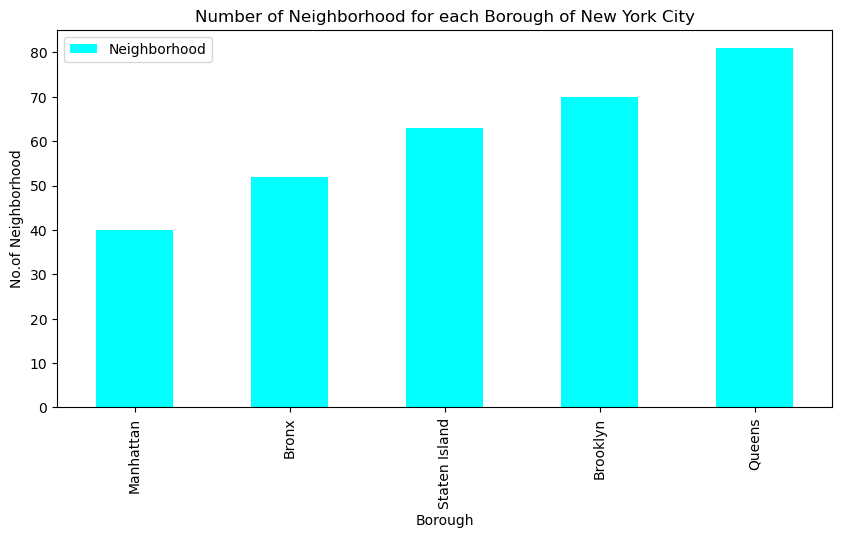

In [12]:
plt.figure(figsize=(10,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough of New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 10)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=10)
#giving a bar plot
#values = new_york_data.groupby('Borough')['Neighborhood'].count()
new_york_data.groupby('Borough')['Neighborhood'].count().sort_values().plot(kind='bar' , color= "cyan")
#legend
plt.legend()
#displays the plot
plt.show()

In [13]:
man_data = new_york_data[new_york_data['Borough']=='Manhattan']
#print(man_data.head())
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
Pizza_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in man_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude = row
    venues = get_venues(Latitude,Longitude)
    #print(venues)
    Pizza_resturants=venues[venues['Category']=='Pizza Place']  
    print('(',count,'/',len(man_data),')','Pizza Resturants in '+Neighborhood+', '+Borough+':'+str(len(Pizza_resturants)))
    for resturant_detail in Pizza_resturants.values.tolist():
        id, name , category = resturant_detail
        Pizza_rest_ny = Pizza_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count += 1

( 1 / 40 ) Pizza Resturants in Marble Hill, Manhattan:4
( 2 / 40 ) Pizza Resturants in Chinatown, Manhattan:2
( 3 / 40 ) Pizza Resturants in Washington Heights, Manhattan:6
( 4 / 40 ) Pizza Resturants in Inwood, Manhattan:4
( 5 / 40 ) Pizza Resturants in Hamilton Heights, Manhattan:2
( 6 / 40 ) Pizza Resturants in Manhattanville, Manhattan:2
( 7 / 40 ) Pizza Resturants in Central Harlem, Manhattan:3
( 8 / 40 ) Pizza Resturants in East Harlem, Manhattan:4
( 9 / 40 ) Pizza Resturants in Upper East Side, Manhattan:1
( 10 / 40 ) Pizza Resturants in Yorkville, Manhattan:4
( 11 / 40 ) Pizza Resturants in Lenox Hill, Manhattan:3
( 12 / 40 ) Pizza Resturants in Roosevelt Island, Manhattan:4
( 13 / 40 ) Pizza Resturants in Upper West Side, Manhattan:2
( 14 / 40 ) Pizza Resturants in Lincoln Square, Manhattan:1
( 15 / 40 ) Pizza Resturants in Clinton, Manhattan:1
( 16 / 40 ) Pizza Resturants in Midtown, Manhattan:2
( 17 / 40 ) Pizza Resturants in Murray Hill, Manhattan:3
( 18 / 40 ) Pizza Restur

In [14]:
 Pizza_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Manhattan,Marble Hill,4b4429abf964a52037f225e3,Arturo's
1,Manhattan,Marble Hill,4bb114c4f964a520b9783ce3,Sam's Pizza
2,Manhattan,Marble Hill,4be72770910020a16f1ad514,Broadway Pizza & Pasta
3,Manhattan,Marble Hill,502bd9a6e4b0bea49203e0aa,Little Caesars Pizza
4,Manhattan,Chinatown,56c3c626cd106998d2b196d0,Scarr's Pizza


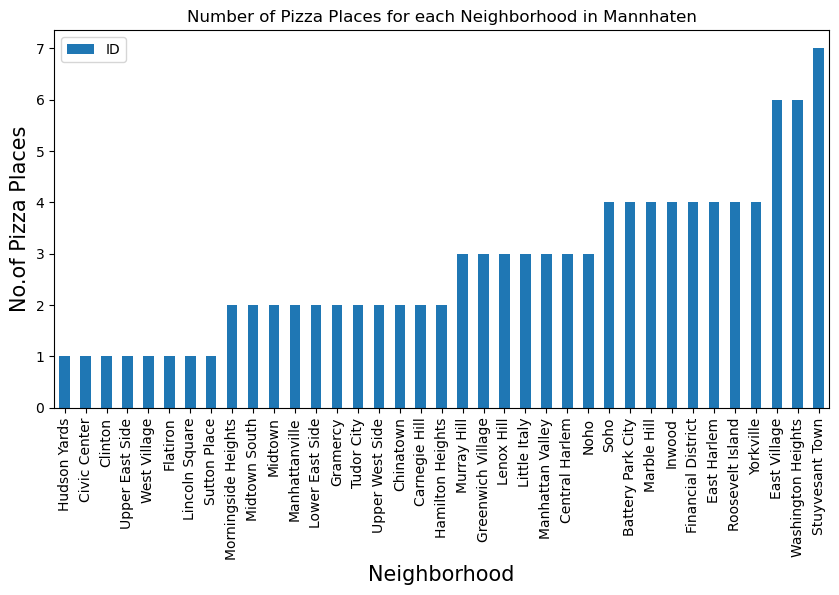

In [15]:
plt.figure(figsize=(10,5), dpi = 100)
# title
plt.title('Number of Pizza Places for each Neighborhood in Mannhaten')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Pizza Places', fontsize=15)
#giving a bar plot
Pizza_rest_ny.groupby('Neighborhood')['ID'].count().sort_values().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [16]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude_x = location.latitude
longitude_y = location.longitude
print('The Geograpical Co-ordinate of Seattle,Washington are {}, {}.'.format(latitude_x, longitude_y))

The Geograpical Co-ordinate of Seattle,Washington are 40.7127281, -74.0060152.


In [17]:
map_Newyork = folium.Map(location=[latitude_x, longitude_y], zoom_start=10, tiles="OpenStreetMap")

man_data = new_york_data[new_york_data['Borough'] == "Manhattan"]
rest_data = new_york_data[new_york_data['Borough'] != "Manhattan"]

for lat, lng, nei in zip(rest_data['Latitude'], rest_data['Longitude'], rest_data['Neighborhood']):
    label = '{}'.format(nei)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Newyork)  
    
for lat, lng, nei in zip(man_data['Latitude'], man_data['Longitude'], man_data['Neighborhood']):
    label = '{}'.format(nei)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Newyork)  
    
map_Newyork

In [62]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
Pizza_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in Pizza_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips =venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(Pizza_rest_ny),')','processed')
    Pizza_rest_stats_ny = Pizza_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips,
                                               }, ignore_index=True)
    count += 1

                         ID      Name  Likes  Rating  Tips
0  4b4429abf964a52037f225e3  Arturo's     16     8.2    17
( 1 / 102 ) processed
                         ID         Name  Likes  Rating  Tips
0  4bb114c4f964a520b9783ce3  Sam's Pizza     29     8.9    17
( 2 / 102 ) processed
                         ID                    Name  Likes  Rating  Tips
0  4be72770910020a16f1ad514  Broadway Pizza & Pasta     12     7.4     2
( 3 / 102 ) processed
                         ID                  Name  Likes  Rating  Tips
0  502bd9a6e4b0bea49203e0aa  Little Caesars Pizza      6     6.6     1
( 4 / 102 ) processed
                         ID           Name  Likes  Rating  Tips
0  56c3c626cd106998d2b196d0  Scarr's Pizza    237     9.1    61
( 5 / 102 ) processed
                         ID                     Name  Likes  Rating  Tips
0  557a7031498e4837f11ba9e2  Champion Pizza - Ludlow    242     9.2    16
( 6 / 102 ) processed
                         ID               Name  Likes  Rating 

In [63]:
Pizza_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Manhattan,Marble Hill,4b4429abf964a52037f225e3,Arturo's,16,8.2,17
1,Manhattan,Marble Hill,4bb114c4f964a520b9783ce3,Sam's Pizza,29,8.9,17
2,Manhattan,Marble Hill,4be72770910020a16f1ad514,Broadway Pizza & Pasta,12,7.4,2
3,Manhattan,Marble Hill,502bd9a6e4b0bea49203e0aa,Little Caesars Pizza,6,6.6,1
4,Manhattan,Chinatown,56c3c626cd106998d2b196d0,Scarr's Pizza,237,9.1,61


In [64]:
Pizza_rest_stats_ny['Likes']=Pizza_rest_stats_ny['Likes'].astype('float64')
Pizza_rest_stats_ny['Tips']=Pizza_rest_stats_ny['Tips'].astype('float64')

In [65]:
Pizza_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102 entries, 0 to 101
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       102 non-null    object 
 1   Neighborhood  102 non-null    object 
 2   ID            102 non-null    object 
 3   Name          102 non-null    object 
 4   Likes         102 non-null    float64
 5   Rating        102 non-null    float64
 6   Tips          102 non-null    float64
dtypes: float64(3), object(4)
memory usage: 5.7+ KB


In [95]:
Pizza_rest_stats_ny = Pizza_rest_stats_ny.sort_values(by=['Likes','Rating','Tips'], axis=0, ascending = False)
Pizza_rest_stats_ny

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
50,Manhattan,Greenwich Village,45ebc982f964a52091431fe3,Joe's Pizza,1461.0,8.9,451.0
61,Manhattan,Little Italy,4f045eeb00399761c77301e3,Prince Street Pizza,1440.0,9.2,365.0
64,Manhattan,Soho,4f045eeb00399761c77301e3,Prince Street Pizza,1440.0,9.2,365.0
86,Manhattan,Noho,4f045eeb00399761c77301e3,Prince Street Pizza,1440.0,9.2,365.0
60,Manhattan,Little Italy,55ea9f4d498ed46db0383483,Champion Pizza,1233.0,9.2,149.0
62,Manhattan,Soho,55ea9f4d498ed46db0383483,Champion Pizza,1233.0,9.2,149.0
73,Manhattan,Gramercy,51351c3fe4b0c58b63965114,Joe's Pizza,965.0,9.1,167.0
89,Manhattan,Midtown South,4a639f9ff964a52077c51fe3,New York Pizza Suprema,889.0,8.9,335.0
54,Manhattan,East Village,4aaec606f964a5203d6320e3,Motorino,780.0,8.8,322.0
97,Manhattan,Stuyvesant Town,4aaec606f964a5203d6320e3,Motorino,780.0,8.8,322.0


In [96]:
ny_neigh_stats=Pizza_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating','Likes']]
ny_neigh_stats.columns=['Neighborhood','Average Rating','Average Likes']
ny_neigh_stats.sort_values(by = ['Average Likes'],ascending=False).head()

,Neighborhood,Average Rating,Average Likes
17,Little Italy,9.100000,1010.000000
28,Soho,9.050000,838.000000
11,Greenwich Village,8.966667,762.666667
35,West Village,8.900000,686.000000
10,Gramercy,9.100000,657.500000


In [97]:
ny_neigh_stats=pd.merge(ny_neigh_stats,new_york_data, on='Neighborhood')
ny_neigh_stats=ny_neigh_stats[['Neighborhood','Latitude','Longitude','Average Rating','Average Likes']]
ny_neigh_stats.head()


,Neighborhood,Latitude,Longitude,Average Rating,Average Likes
0,Battery Park City,40.711932,-74.016869,8.475,121.250000
1,Carnegie Hill,40.782683,-73.953256,9.000,174.500000
2,Central Harlem,40.815976,-73.943211,8.300,40.333333
3,Chinatown,40.715618,-73.994279,9.150,239.500000
4,Civic Center,40.715229,-74.005415,8.900,77.000000


In [98]:
ny_neigh_stats= ny_neigh_stats[(ny_neigh_stats['Average Rating']>=9) & (ny_neigh_stats['Average Likes'] > 100) ]

In [99]:
ny_neigh_stats.head(5)

,Neighborhood,Latitude,Longitude,Average Rating,Average Likes
1,Carnegie Hill,40.782683,-73.953256,9.00,174.5
3,Chinatown,40.715618,-73.994279,9.15,239.5
9,Flatiron,40.739673,-73.990947,9.10,225.0
10,Gramercy,40.737210,-73.981376,9.10,657.5
17,Little Italy,40.719324,-73.997305,9.10,1010.0


In [100]:
map_Newyork2 = folium.Map(location=[latitude_x, longitude_y], zoom_start=10, tiles="OpenStreetMap")
# loop through the neighborhood and add each to the feature group

In [101]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the neighborhood and add each to the feature group
for lat, lng, in ny_neigh_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=2, # define how big you want the circle markers to be
            color='green',
            fill=True,
            fill_color='blue',
            fill_opacity=0.2
        )
    )

In [102]:

ny_neigh_stats['Label']=ny_neigh_stats['Neighborhood']+'(Likes='+ny_neigh_stats['Average Likes'].map(str)+', Rating='+ny_neigh_stats['Average Rating'].map(str)+')'
# add pop-up text to each marker on the map
for lat, lng, label in ny_neigh_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(map_Newyork2)    
    
map_Newyork2.add_child(incidents)
map_Newyork2
